<a href="https://colab.research.google.com/github/robinhester/DS-Unit-2-Applied-Modeling/blob/master/module4-model-interpretation/Model_Interpretation_LS_DS_234_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd 

In [0]:
got=pd.read_csv('https://raw.githubusercontent.com/robinhester/DS-Unit-2-Applied-Modeling/master/data/gameofthrones.csv')

In [0]:
def data_wrangle(X):
  X=X.copy()

  duplicate=['Unnamed: 0', 'S.No', 'actual', 
             'pred', 'alive', 'plod']

  X=X.drop(columns=duplicate)

  X=X.fillna('Missing')

  leakage=['DateoFdeath', 'book1', 'book2', 
           'book3', 'book4','book5']

  X=X.drop(columns=leakage)

  top7houses=["Night's Watch", 'House Frey','House Stark',
              'House Stark','House Targaryen','House Lannister',
              'House Greyjoy','House Tyrell']

  X.loc[~X['house'].isin(top7houses),'house']== 'Other'

  top5=['Ser','Maester','Archmaester','Lord',
        'Septon','Winterfell','Missing']

  X.loc[~X['title'].isin(top5),'title']=='Other'
  X.title.replace('Missing','No Title')

  X['Female']=X.male == 0
  X.male.replace(1, 'True')
  X.male.replace(0,'False')

  X.isAliveMother.replace(1,'True')
  X.isAliveMother.replace(0,'False')

  X.isAliveFather.replace(1,'True')
  X.isAliveFather.replace(0,'False')

  X.isAliveHeir.replace(1,'True')
  X.isAliveHeir.replace(0,'False')

  X.isAliveSpouse.replace(1,'True')
  X.isAliveSpouse.replace(0,'False')

  X.isMarried.replace(1,'True')
  X.isMarried.replace(0,'False')

  X.isNoble.replace(1,'True')
  X.isNoble.replace(0,'False')

  return X

In [0]:
from sklearn.model_selection import train_test_split
train=got.copy()
train, test = train_test_split(train, train_size=.80, test_size=.20, 
                              stratify=train['isAlive'], random_state=42)

train, val = train_test_split(train, test_size=len(test), 
                              stratify=train['isAlive'], random_state=42)

In [0]:
train=data_wrangle(train)
val=data_wrangle(val)
test=data_wrangle(test)

In [6]:
!pip install category_encoders

     |████████████████████████████████| 102kB 2.4MB/s 


In [0]:
target='isAlive'
features= train.drop(columns=[target]).columns
# print(features)
x_train=train[features]
y_train=train[target]
# y_train
x_val=val[features]
y_val=val[target]
#x_test
x_test=test[features]
y_test=test[target]

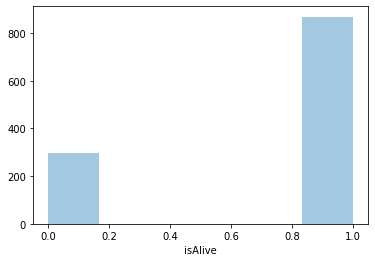

In [8]:
%matplotlib inline
import seaborn as sns
sns.distplot(y_train, kde=False);

In [0]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [12]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(x_train, y_train)
y_pred = gb.predict(x_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Gradient Boosting R^2 -0.023201848897629995


In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72


In [15]:
!pip install pdpbox

     |████████████████████████████████| 57.7MB 72kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=41344fc189d73acfe0bf94629e60787d7a3222a7b4b1383e37129c36c4eab395
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'popularity'

isolated = pdp_isolate(
    model=gb,
    dataset=x_val,
    model_features=x_val.columns,
    num_grid_points=50,
    feature=feature
)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7faf78f8d390>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7faf791e7518>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


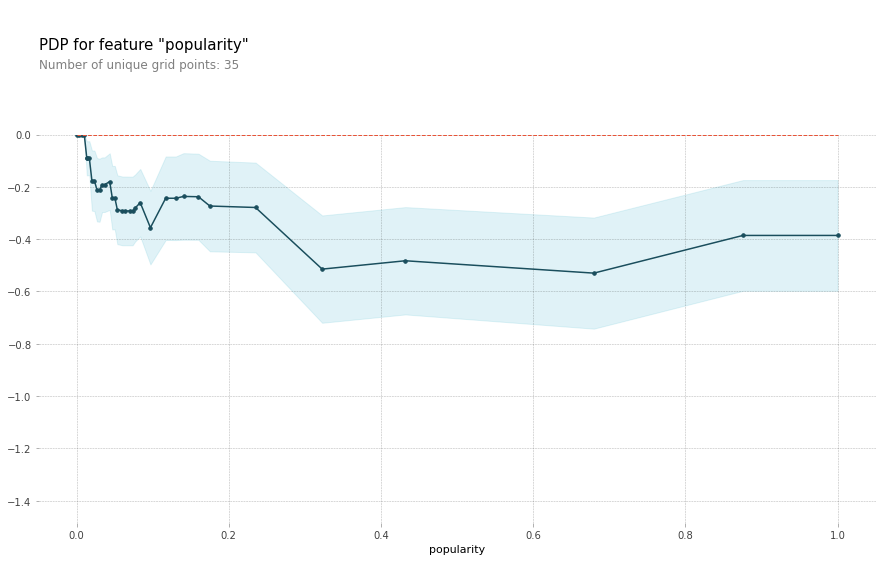

In [17]:
pdp_plot(isolated, feature_name=feature)

TypeError: ignored

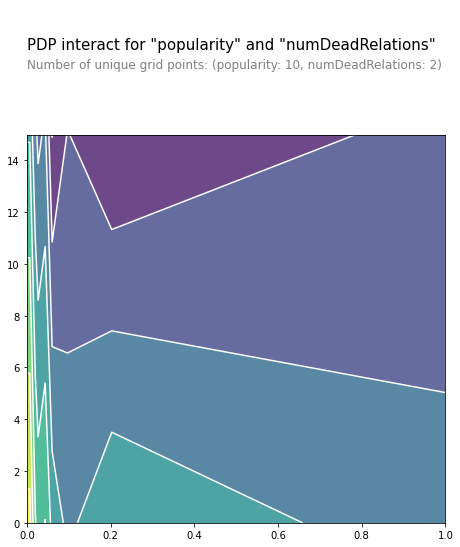

In [22]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['popularity', 'numDeadRelations']

interaction = pdp_interact(
    model=gb,
    dataset=x_val,
    model_features=x_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='contour', feature_names=features);

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


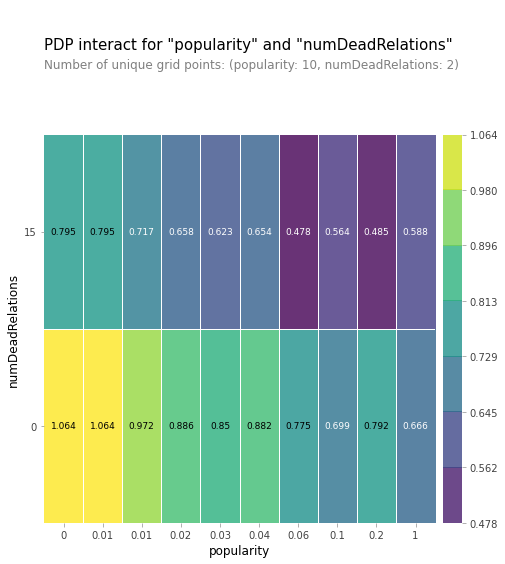

In [23]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

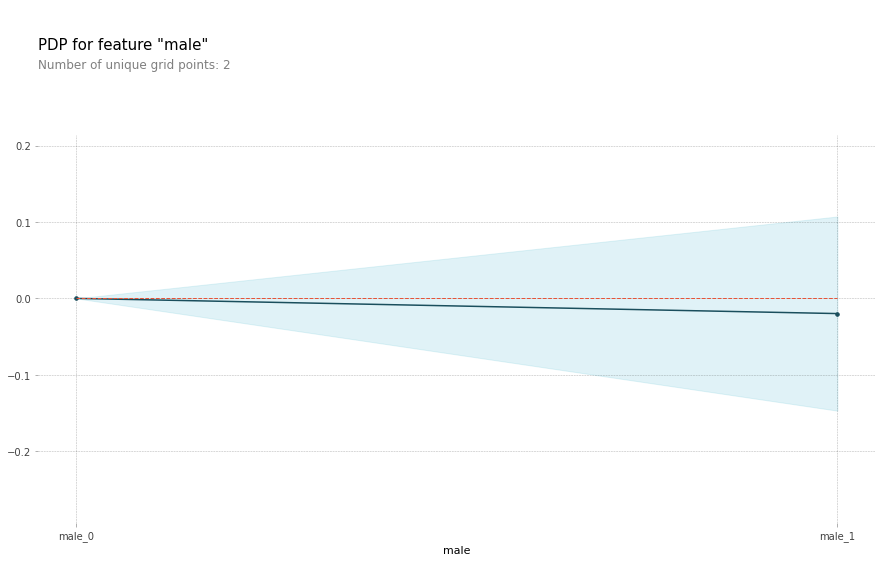

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp

target='isAlive'
features= train.drop(columns=[target]).columns
# print(features)
x_train=train[features]
y_train=train[target]
# y_train
x_val=val[features]
y_val=val[target]
#x_test
x_test=test[features]
y_test=test[target]

encoder = ce.OrdinalEncoder()
x_encoded = encoder.fit_transform(x_train)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(x_encoded, y_train)
feature = 'male'
pdp_dist = pdp.pdp_isolate(model=model, dataset=x_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

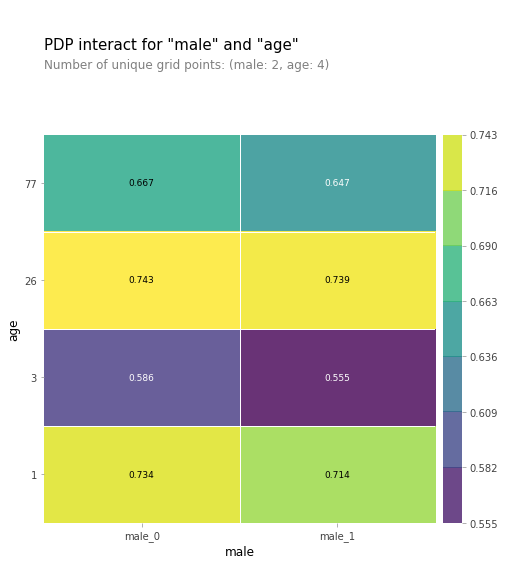

In [27]:
features = ['male', 'age']

interaction = pdp_interact(
    model=model, 
    dataset=x_encoded, 
    model_features=x_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [29]:
!pip install shap

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394121 sha256=a0abb812ded8490e4106152c77852913f57411a058bd203811c93f3c18304586
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [42]:
from xgboost import XGBClassifier
processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

x_train_processed = processor.fit_transform(x_train)
x_val_processed = processor.transform(x_val)

eval_set = [(x_train_processed, y_train), 
            (x_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(x_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.698845	validation_1-auc:0.672516
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.70123	validation_1-auc:0.671509
[2]	validation_0-auc:0.729778	validation_1-auc:0.677358
[3]	validation_0-auc:0.735311	validation_1-auc:0.690149
[4]	validation_0-auc:0.740291	validation_1-auc:0.689871
[5]	validation_0-auc:0.751227	validation_1-auc:0.687789
[6]	validation_0-auc:0.757965	validation_1-auc:0.686209
[7]	validation_0-auc:0.762429	validation_1-auc:0.687563
[8]	validation_0-auc:0.775587	validation_1-auc:0.685897
[9]	validation_0-auc:0.779004	validation_1-auc:0.687459
[10]	validation_0-auc:0.778799	validation_1-auc:0.688049
[11]	validation_0-auc:0.781765	validation_1-auc:0.689125
[12]	validation_0-auc:0.789392	validation_1-auc:0.701482
[13]	validation_0-auc:0.789682	validation_1-auc:0.701378
[14]	validation_0-auc:0.79051	validation_1-auc:0.70353
[

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [43]:
from sklearn.metrics import roc_auc_score
x_test_processed = processor.transform(x_test)
class_index = 1
y_pred_proba = model.predict_proba(x_test_processed)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba)) # Ranges from 0-1, higher is better

Test ROC AUC for class 1:
0.7184039709812906


In [0]:
row = x_test.iloc[[3]]


In [45]:
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # For classification, this shows predicted probabilities
)